In [8]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
from itertools import product
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [9]:
def manual_error_rate(df, models=None, proba=False, diag=False):
    features = df['feature']
    labels = df['label']

    arr_len = len(features[0])
    tot_enumerations = 2**arr_len

    permutations = list(product([0, 1], repeat=arr_len))

    results = []
    results_p_1 = []
    results_p_2 = []
    results_p_3 = [] ###

    for perm in tqdm(permutations, total=tot_enumerations, desc="Processing permutations"):
        perm_array = np.array(perm)
        count = 0
        error_count = 0

        for feature, label in zip(features, labels):
            if np.array_equal(feature, perm_array):
                count += 1
                if label == 0:
                    error_count += 1
        if count > 0:
          error_rate = (error_count / count)
          results.append([perm, error_rate])
          proba_score = 0
          if proba:
            # probability that prediction is 0
            rf_score = models[0].predict_proba(np.array(perm).reshape(1, -1))[0][0]
            lr_score = models[1].predict_proba(np.array(perm).reshape(1, -1))[0][0]
            kn_score = models[2].predict_proba(np.array(perm).reshape(1, -1))[0][0]
            results_p_1.append([perm, rf_score])
            results_p_2.append([perm, lr_score])
            results_p_3.append([perm, kn_score])
          if diag: print(f"permutation {perm}: manual error rate is {error_rate*100:.2f}%, proba_score is {proba_score*100:.2f}% appears {count} times")

    if proba: return np.array(results, dtype=object), np.array(results_p_1, dtype=object), np.array(results_p_2, dtype=object), np.array(results_p_3, dtype=object)
    else: return np.array(results, dtype=object)


def repopulate_sample(sample, total_manual, model=None, avg=False, val=0):
    tmp = []
    avg_value = np.mean(sample[:, 1].astype(float))
    for i, entry in enumerate(total_manual):
        exist = next((row for row in sample if row[0] == entry[0]), None)
        if exist is not None:
            tmp.append([exist[0], exist[1]])
        else:
            if model is not None:
                tmp.append([entry[0], model.predict_proba(np.array(entry[0]).reshape(1, -1))[0][0]])
            else:
                if avg:
                    tmp.append([entry[0], avg_value])
                else:
                    tmp.append([entry[0], val])
    return np.array(tmp, dtype=object)

def check_overfitting(name, model, X, y, verbose=False):
    train_score = model.score(X, y)
    cv_score = np.mean(cross_val_score(RandomForestClassifier(random_state=42), X, y, cv=5))
    if verbose:
        print(f"{name} Training accuracy: {train_score:.4f}")
        print(f"{name} Cross-validation accuracy: {cv_score:.4f}")
        print(f"Potential overfitting: {abs(train_score - cv_score):.4f}")
    if train_score - cv_score > 0.1:
        print(f"!! WARNING: {name} model may be overfitting, Diff: {abs(train_score - cv_score):.4f}")

def tune_rf(X, y, verbose=False):
    param_grid = {
            'n_estimators': [100, 200, 500],
            'max_depth': [10, 20, 30],
    }

    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1, 
        verbose=1
    )

    print("Performing RF hyperparameter tuning...")
    grid_search.fit(X, y)

    rf = grid_search.best_estimator_
    if verbose:
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    return rf

# Grid Search for Plot Generation

In [ ]:
all_features = np.arange(4, 13)
all_sample_sizes = [100, 500, 5000, 10000]

# all_features = np.arange(4, 6)
# all_sample_sizes = [100, 500, 5000, 10000]


orig_reconstruct = pd.read_csv("rec.csv")
orig_reconstruct["feature"] = orig_reconstruct["feature"].apply(ast.literal_eval)
orig_reconstruct["feature"] = orig_reconstruct["feature"].apply(lambda x: x[-1:] + x[:-1])

#grid search features and sample sizes (brute force all and get array of all combination [ratio, hardness])

all_rfv = []
all_rlv = []
all_knv = []
all_msv = []

results = []
for feature_size in all_features:
    print(f" ---- Testing feature size: {feature_size} ---- ")
    # ---- Load CNN Model Preds ----
    #clip each feature from the right (.ie if each feature has length 14 and i spefcify feature size of 12, remove the right 2 elements from each feature)
    reconstruct = orig_reconstruct.copy()
    reconstruct["feature"] = reconstruct["feature"].apply(lambda x: x[:feature_size])
    print("Calculating Total Manual Error Rates")
    total_manual = manual_error_rate(reconstruct)

    for sample_size in all_sample_sizes:
        print(f"## Sample size: {sample_size}")
        # ---- Sample Set ----
        sample_set = reconstruct.sample(n=sample_size, random_state=42).reset_index(drop=True)
        X = list(sample_set['feature'])
        y = sample_set['label']

        # ---- Error Pred Models ----
        rf = tune_rf(X, y, verbose=False)

        lr = LogisticRegression(random_state=42)
        lr.fit(X, y)
        knn = KNeighborsClassifier() ###
        knn.fit(X, y)###

        # --- Overfitting Check ---
        check_overfitting("Random Forest", rf, X, y, verbose=False)
        check_overfitting("Logistic Regression", lr, X, y, verbose=False)
        check_overfitting("KNN", knn, X, y, verbose=False)

        # ---- Calculate all 3 Error Rates ----
        print("Calculating Sample Manual and Proba Error Rates")
        manual_sample, rf_sample, lr_sample, knn_sample = manual_error_rate(sample_set, models=[rf, lr, knn], proba=True, diag=False)
        manual_sample = repopulate_sample(manual_sample, total_manual, val=0)
        
        rf_sample = repopulate_sample(rf_sample, total_manual, model=rf)
        lr_sample = repopulate_sample(lr_sample, total_manual, model=lr)
        knn_sample = repopulate_sample(knn_sample, total_manual, model=knn)


        ### STOP HERE... I currently have manual and model errors



        rf_vs_mt = np.sum((total_manual[:, 1] - rf_sample[:, 1]) ** 2)
        lr_vs_mt = np.sum((total_manual[:, 1] - lr_sample[:, 1]) ** 2)
        knn_vs_mt = np.sum((total_manual[:, 1] - knn_sample[:, 1]) ** 2)
        ms_vs_mt = np.sum((total_manual[:, 1] - manual_sample[:, 1]) ** 2)

        all_rfv.append(rf_vs_mt)
        all_rlv.append(lr_vs_mt)
        all_knv.append(knn_vs_mt)
        all_msv.append(ms_vs_mt)

        rf_ratio = rf_vs_mt / ms_vs_mt
        lr_ratio = lr_vs_mt / ms_vs_mt
        knn_ratio = knn_vs_mt / ms_vs_mt
        hardness = sample_size / (2 ** feature_size)
        print(f"-> RF Ratio: {rf_ratio:.2f}, LR Ratio: {lr_ratio:.2f}, KNN Ratio: {knn_ratio:.2f}, Hardness: {hardness:.2f}")
        results.append([feature_size, sample_size, rf_ratio, lr_ratio, knn_ratio, hardness])
    
    print()

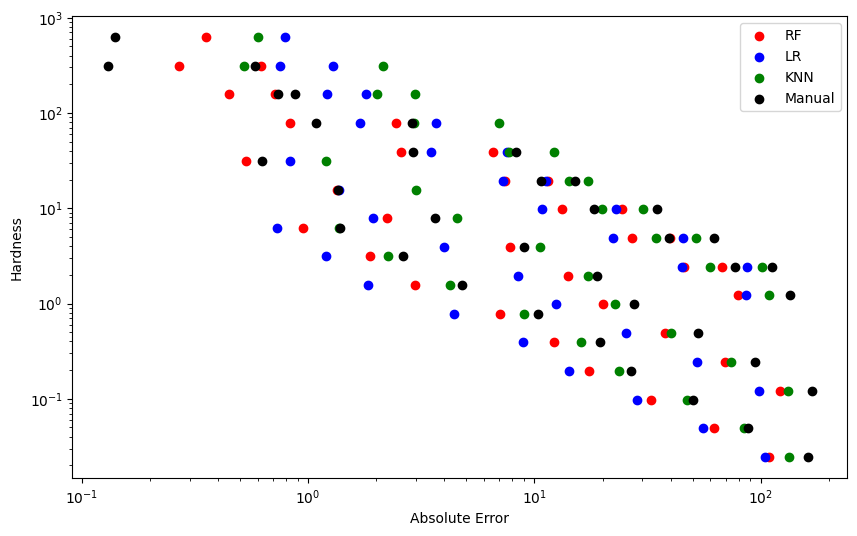

In [31]:
#plot absolute values of allrfv, allrlv, allknv, allmsv vs hardness and plot them in different colors

results = np.array(results)
all_rfv = np.array(all_rfv)
all_rlv = np.array(all_rlv)
all_knv = np.array(all_knv)
all_msv = np.array(all_msv)

plt.figure(figsize=(10, 6))
plt.scatter(abs(all_rfv), results[:, 5], color='red', label='RF')
plt.scatter(abs(all_rlv), results[:, 5], color='blue', label='LR')
plt.scatter(abs(all_knv), results[:, 5], color='green', label='KNN')
plt.scatter(abs(all_msv), results[:, 5], color='black', label='Manual')
plt.xlabel('Absolute Error')
plt.ylabel('Hardness')
#log scale
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()



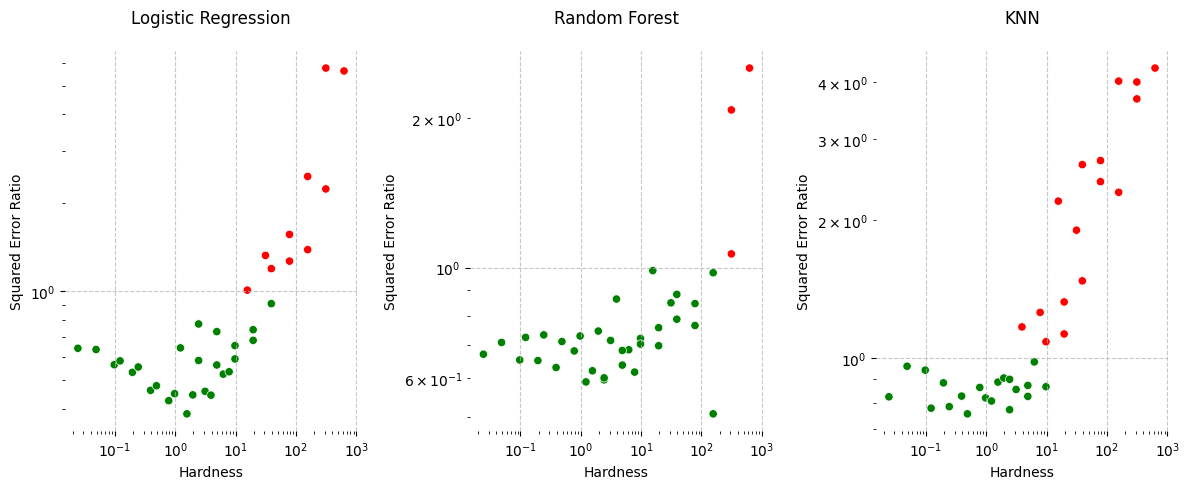

RF: 91.67% are below 1
LR: 72.22% are below 1
KNN: 55.56% are below 1


In [32]:
np_results = np.array(results)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Left plot: using y column index 3
sns.scatterplot(ax=axes[0],
                x=np_results[:, 5],
                y=np_results[:, 3],
                hue=np_results[:, 3] < 1,
                palette={True: 'green', False: 'red'},
                legend=False)
axes[0].set_xlabel('Hardness')
axes[0].set_ylabel('Squared Error Ratio')
axes[0].set_title('Logistic Regression', pad=20)
axes[0].grid(True, linestyle='--', alpha=0.7)
for spine in axes[0].spines.values():
    spine.set_visible(False)
# Apply log scale to both axes for left plot
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# Right plot: using y column index 2
sns.scatterplot(ax=axes[1],
                x=np_results[:, 5],
                y=np_results[:, 2],
                hue=np_results[:, 2] < 1,
                palette={True: 'green', False: 'red'},
                legend=False)
axes[1].set_xlabel('Hardness')
axes[1].set_ylabel('Squared Error Ratio')
axes[1].set_title('Random Forest', pad=20)
axes[1].grid(True, linestyle='--', alpha=0.7)
for spine in axes[1].spines.values():
    spine.set_visible(False)
# Apply log scale to both axes for right plot
axes[1].set_xscale('log')
axes[1].set_yscale('log')

sns.scatterplot(ax=axes[2],
                x=np_results[:, 5],
                y=np_results[:, 4],
                hue=np_results[:, 4] < 1,
                palette={True: 'green', False: 'red'},
                legend=False)
axes[2].set_xlabel('Hardness')
axes[2].set_ylabel('Squared Error Ratio')
axes[2].set_title('KNN', pad=20)
axes[2].grid(True, linestyle='--', alpha=0.7)
for spine in axes[2].spines.values():
    spine.set_visible(False)
# Apply log scale to both axes for right plot
axes[2].set_xscale('log')
axes[2].set_yscale('log')


plt.tight_layout()
plt.show()

rf_percentage = np.sum(np_results[:, 2] < 1) / len(np_results)
lr_percentage = np.sum(np_results[:, 3] < 1) / len(np_results)
knn_percentage = np.sum(np_results[:, 4] < 1) / len(np_results)
print(f"RF: {rf_percentage*100:.2f}% are below 1")
print(f"LR: {lr_percentage*100:.2f}% are below 1")
print(f"KNN: {knn_percentage*100:.2f}% are below 1")


#save results